Exercise 10.

Neural machine translation with attention Tutorial  
https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import os

DATASETS_DIR = os.path.join(os.pardir, 'datasets')
FRA_ENG_DIR = os.path.join(DATASETS_DIR, 'fra-eng')
FRA_DIR = os.path.join(FRA_ENG_DIR, 'fra.txt')

In [3]:
with open(FRA_DIR, encoding='utf8') as f:
    lines = f.readlines()
    pairs = [line.split('\t') for line in lines]

In [4]:
pairs[-1]

['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
 "Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.",
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2024159 (CK) & #2024564 (sacredceltic)\n']

In [5]:
fra = [fra for eng, fra, _ in pairs]
eng = [eng for eng, fra, _ in pairs]

In [6]:
fra[-1]

"Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs."

In [7]:
eng[-1]

'It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.'

In [8]:
BUFFER_SIZE = len(fra)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((fra, eng)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Nous en sommes en partie responsables.'
 b'Si vous \xc3\xaates fatigu\xc3\xa9, reposez-vous !'
 b'As-tu fini tes devoirs ?' b'Les enfants dorment-ils\xc2\xa0?'
 b'Les richards ont de nombreux amis.'], shape=(5,), dtype=string)

tf.Tensor(
[b'We are in part responsible for it.' b"If you're tired, rest."
 b'Have you finished your homework?' b'Are the children asleep?'
 b'The rich have many friends.'], shape=(5,), dtype=string)


In [10]:
import tensorflow_text as tf_text

example_text = tf.constant('être né dans le neuvième')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc3\xaatre n\xc3\xa9 dans le neuvi\xc3\xa8me'
b'e\xcc\x82tre ne\xcc\x81 dans le neuvie\xcc\x80me'


In [11]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

être né dans le neuvième
[START] etre ne dans le neuvieme [END]


In [13]:
from tensorflow.keras.layers.experimental import preprocessing

max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size)

In [14]:
input_text_processor.adapt(fra)

input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [15]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size)

output_text_processor.adapt(eng)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [16]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   22,   23,   96,   23,  377, 3102,    4,    3,    0],
       [   2,   49,   14,   88,  412,   18,    1,   34,    3,    0],
       [   2,  103,  383,  168,  558,    8,    3,    0,    0,    0]],
      dtype=int64)>

In [17]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] nous en sommes en partie responsables . [END]        '

Text(0.5, 1.0, 'Mask')

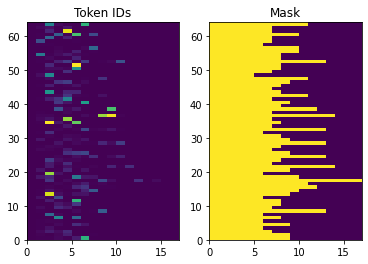

In [18]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')